In [60]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from torch_geometric.datasets import Planetoid

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import graph_tool as gt
import graph_tool.generation as gen
import graph_tool.topology as top
import networkx as nx

In [32]:
from substructures import get_rings, get_substructure_edge_index, get_node_counts
def pre_transform(graph):
    triangles = get_rings(graph.edge_index, max_k =3)
    substructures_edge_index = [get_substructure_edge_index(substructure) for substructure in [triangles]]
    return graph.update({"substructures_edge_index": substructures_edge_index, "y": get_node_counts(triangles, graph.num_nodes), "x": torch.zeros((graph.num_nodes,1))})

In [33]:
from torch_geometric.datasets import TUDataset
DATASET_NAME = "ENZYMES"
dataset = TUDataset(root=f'/tmp/{DATASET_NAME}_node_level', name=DATASET_NAME, pre_transform = pre_transform, use_node_attr= True)

Processing...
Done!


In [51]:
g = to_networkx(dataset[0], to_undirected=True)
pos = nx.spring_layout(g)
pos

{0: array([-0.86133902, -0.32313412]),
 1: array([-0.76702658, -0.34564548]),
 2: array([-0.73991073, -0.40322844]),
 3: array([-0.68132173, -0.27950813]),
 4: array([-0.54977375, -0.1810366 ]),
 5: array([-0.49641792, -0.21861744]),
 6: array([-0.43588309, -0.09871105]),
 7: array([-0.33444765, -0.20177704]),
 8: array([-0.29024728, -0.11122298]),
 9: array([-0.21984151, -0.28206469]),
 10: array([-0.23470241, -0.34998824]),
 11: array([-0.2198978 , -0.46722045]),
 12: array([-0.1679297 , -0.42917329]),
 13: array([ 0.1949643 , -0.37953653]),
 14: array([ 0.21034838, -0.4312993 ]),
 15: array([ 0.37909808, -0.34549504]),
 16: array([ 0.34600077, -0.30237625]),
 17: array([ 0.47840076, -0.11965185]),
 18: array([0.57065998, 0.10299572]),
 19: array([0.51059191, 0.10925586]),
 20: array([0.52102812, 0.34858586]),
 21: array([0.46220444, 0.51844471]),
 22: array([0.50194047, 0.47710336]),
 23: array([0.57374027, 0.52972409]),
 24: array([-0.61497641, -0.37050312]),
 25: array([-0.0720592

In [57]:
def test(a=2):
    print(a)

kwargs = {"a":2,"b":5}
test(**kwargs)

TypeError: test() got an unexpected keyword argument 'b'

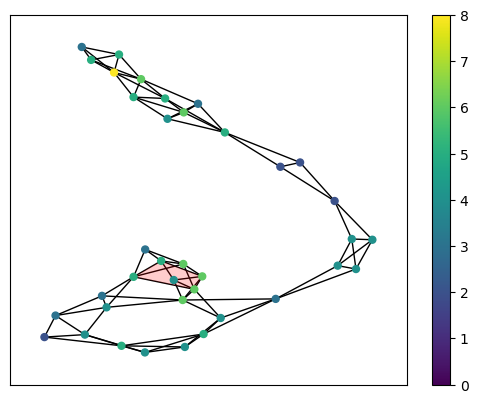

In [69]:
import visualization as vis
vis.visualize(dataset[0], substructure=get_rings(dataset[0].edge_index, max_k = 4, min_k=4)[1:2], node_color = dataset[0].y)

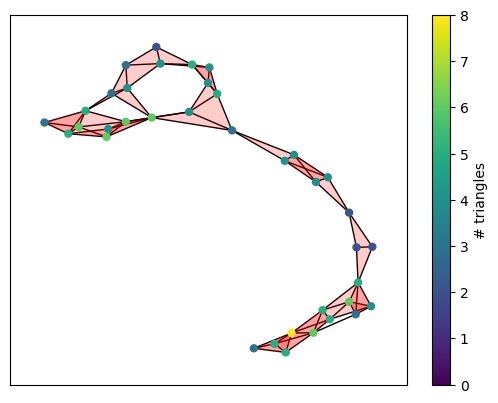

In [56]:
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
from matplotlib import cm, colors
g = to_networkx(dataset[0], to_undirected=True)
pos = nx.spring_layout(g)
nx.draw_networkx(g, pos = pos, with_labels=False, node_color=dataset[0].y, vmin = 0, vmax = max(dataset[0].y), cmap= "viridis", node_size = 25)
for triangle in get_rings(dataset[0].edge_index, max_k =3):
    t = plt.Polygon([pos[node] for node in triangle], facecolor = "red", alpha = 0.2)
    plt.gca().add_patch(t)
norm = colors.Normalize(0, max(dataset[0].y))
cmap = cm.get_cmap("viridis")
plt.gcf().colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=plt.gca(), label = "# triangles")
plt.show()

In [13]:
if enable_wandb:
    wandb.init(project='triangle-square-counting')
    summary = dict()
    summary["data"] = dict()
    summary["data"]["num_features"] = data.num_features
    summary["data"]["num_nodes"] = data.num_nodes
    summary["data"]["num_edges"] = data.num_edges 
    summary["data"]["has_isolated_nodes"] = data.has_isolated_nodes()
    summary["data"]["has_self_nodes"] = data.has_self_loops()
    summary["data"]["is_undirected"] = data.is_undirected()
    summary["data"]["num_training_nodes"] = data.train_mask.sum()
    wandb.summary = summary

In [13]:
from simple_model_triangles import SimpleSubstructureNeuralNet

In [24]:
model = SimpleSubstructureNeuralNet(hidden_channels = 16, out_channels = 1,in_channels = dataset.num_node_features, num_layers = 3, num_substructures=2)
print(model)

SimpleSubstructureNeuralNet(
  (layers): ModuleList(
    (0): SubstructureLayer(
      (message_neighbor): GINConv(nn=Sequential(
        (0): Linear(in_features=1433, out_features=32, bias=True)
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=32, out_features=16, bias=True)
      ))
      (node2substructures): ModuleList(
        (0-1): 2 x Sequential(
          (0): Linear(in_features=16, out_features=32, bias=True)
          (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Linear(in_features=32, out_features=16, bias=True)
        )
      )
      (substructures2node): ModuleList(
        (0-1): 2 x Sequential(
          (0): Linear(in_features=16, out_features=32, bias=True)
          (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Linear(in_f

In [13]:
import torch
import torch.nn.functional as F
from torch.nn import Embedding, ModuleList
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU
#from torch_scatter import scatter
from torch_geometric.nn import GINConv, GINEConv

class SimpleGraphNeuralNet(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, out_channels, num_layers):
        
        super(SimpleGraphNeuralNet, self).__init__()
        self.num_layers = num_layers

        self.node_convs = ModuleList()

        for layer in range(num_layers):
            if layer == 0:
                nn = Sequential(
                Linear(input_channels, 2 * hidden_channels),
                BatchNorm1d(2 * hidden_channels),
                ReLU(),
                Linear(2 * hidden_channels, hidden_channels),
            )
            else:
                nn = Sequential(
                    Linear(hidden_channels, 2 * hidden_channels),
                    BatchNorm1d(2 * hidden_channels),
                    ReLU(),
                    Linear(2 * hidden_channels, hidden_channels),
                )
            self.node_convs.append(GINConv(nn, train_eps=True))

        self.lin = Linear(hidden_channels, out_channels)

    def reset_parameters(self):

        for conv in self.node_convs:
            conv.reset_parameters()

        self.lin.reset_parameters()

    def forward(self, data):
        x = data.x

        for i in range(self.num_layers):

            x = self.node_convs[i](x=x, edge_index=data.edge_index)


        #x = scatter(x, data.batch, dim=0, reduce='mean')
        #x = F.dropout(x, self.dropout, training=self.training)
        x = self.lin(x)


        #x = F.relu(x)
        #x = F.dropout(x, self.dropout, training=self.training)
        #x = self.lin(x)
        return x

model2 = SimpleGraphNeuralNet(dataset.num_node_features, 16, 1, 3)

In [14]:
model = model2

In [25]:
from trainer import GraphNet
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
from torch_geometric.loader import DataLoader
wandb_logger = WandbLogger(project='triangle-square-counting', name= "square counting")

train_loader = DataLoader([data])
val_loader = DataLoader([data])
test_loader = DataLoader([data])

trainer = Trainer(max_epochs=200, logger= wandb_logger, enable_progress_bar= False, log_every_n_steps=1)
model_lightning = GraphNet(model)

trainer.fit(model_lightning, train_dataloaders=train_loader, val_dataloaders= val_loader)
wandb.finish()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type                        | Params
------------------------------------------------------
0 | model | SimpleSubstructureNeuralNet | 62.4 K
------------------------------------------------------
62.4 K    Trainable params
0         Non-trainable params
62.4 K    Total params
0.250     Total estimated model params size (MB)
/Users/niklas/anaconda3/envs/substructureML/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/niklas/anaconda3/envs/substructureML/lib/python3.8/site-packages/pytorch_lightning/train

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▃▁▁▁▆▆▆▇▇▇▇▇▇▇▇█████████████████████████
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,199
trainer/global_step,199
training_loss,0.00179
val_acc,0.95
val_loss,0.16753


In [16]:
criterion = F.mse_loss  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = torch.squeeze(model(data))  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = torch.squeeze(model(data))
      pred = torch.round(out)  # Round to integer
      test_loss = criterion(out[data.test_mask], data.y[data.test_mask])
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc, test_loss

#model.reset_parameters()
for epoch in range(1, 201):
    loss = train()
    test_acc, test_loss = test()
    if enable_wandb:
        wandb.log({"substructureGNN/loss": loss, "substructureGNN/test_loss": test_loss, "substructureGNN/test_acc": test_acc})
    
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Loss: 22.6870, Test Loss: 1377639.5000, Test Acc: 0.3380
Epoch: 002, Loss: 18.0280, Test Loss: 2134068.5000, Test Acc: 0.3210
Epoch: 003, Loss: 13.9008, Test Loss: 2130215.7500, Test Acc: 0.3230
Epoch: 004, Loss: 9.1008, Test Loss: 7259279.5000, Test Acc: 0.1220
Epoch: 005, Loss: 4.8206, Test Loss: 4833816.5000, Test Acc: 0.1040
Epoch: 006, Loss: 3.1381, Test Loss: 4838285.0000, Test Acc: 0.1160
Epoch: 007, Loss: 2.8995, Test Loss: 3538408.5000, Test Acc: 0.1120
Epoch: 008, Loss: 2.6522, Test Loss: 1471323.1250, Test Acc: 0.0930
Epoch: 009, Loss: 2.1090, Test Loss: 564561.2500, Test Acc: 0.1040
Epoch: 010, Loss: 1.8465, Test Loss: 214053.5938, Test Acc: 0.1160
Epoch: 011, Loss: 1.5182, Test Loss: 85462.3906, Test Acc: 0.1440
Epoch: 012, Loss: 1.1052, Test Loss: 34237.3672, Test Acc: 0.1580
Epoch: 013, Loss: 0.9520, Test Loss: 13829.2236, Test Acc: 0.2050
Epoch: 014, Loss: 0.7205, Test Loss: 6009.2241, Test Acc: 0.2380
Epoch: 015, Loss: 0.6002, Test Loss: 2858.5491, Test Acc

wandb: Network error (ConnectionError), entering retry loop.


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(torch.squeeze(out[data.train_mask]), data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 000, Loss: 24.1846
Epoch: 001, Loss: 21.5803
Epoch: 002, Loss: 18.1493
Epoch: 003, Loss: 13.4987
Epoch: 004, Loss: 10.6048
Epoch: 005, Loss: 7.6783
Epoch: 006, Loss: 4.2272
Epoch: 007, Loss: 1.4557
Epoch: 008, Loss: 1.3588
Epoch: 009, Loss: 1.6830
Epoch: 010, Loss: 1.8849
Epoch: 011, Loss: 1.7098
Epoch: 012, Loss: 1.4532
Epoch: 013, Loss: 1.2828
Epoch: 014, Loss: 1.0259
Epoch: 015, Loss: 0.8474
Epoch: 016, Loss: 0.6811
Epoch: 017, Loss: 0.6298
Epoch: 018, Loss: 0.5018
Epoch: 019, Loss: 0.4021
Epoch: 020, Loss: 0.3520
Epoch: 021, Loss: 0.3064
Epoch: 022, Loss: 0.2621
Epoch: 023, Loss: 0.2384
Epoch: 024, Loss: 0.2200
Epoch: 025, Loss: 0.2020
Epoch: 026, Loss: 0.1927
Epoch: 027, Loss: 0.1865
Epoch: 028, Loss: 0.1797
Epoch: 029, Loss: 0.1806
Epoch: 030, Loss: 0.1825
Epoch: 031, Loss: 0.1733
Epoch: 032, Loss: 0.1699
Epoch: 033, Loss: 0.1586
Epoch: 034, Loss: 0.1498
Epoch: 035, Loss: 0.1391
Epoch: 036, Loss: 0.1285
Epoch: 037, Loss: 0.1212
Epoch: 038, Loss: 0.1097
Epoch: 039, Loss: 0.

In [18]:
model.eval()
pred = model(data)
loss = F.mse_loss(torch.squeeze(pred[data.train_mask]), data.y[data.train_mask])
print(f'Loss: {loss:.4f}')

Loss: 0.0136


In [19]:
model.eval()
pred = model(data)
loss = F.mse_loss(torch.squeeze(pred[data.test_mask]), data.y[data.test_mask])
print(f'Loss: {loss:.4f}')

Loss: 0.0190


In [4]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

Accuracy: 0.6010


In [10]:
dataset[0].edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [12]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.7980
